## Potential predictions/classifications to make:
- Predicting if a instance of terrorism is doubted as terrorism proper (doubterr)
- Predicting # of terrorists in an attack (nperps) or # of terrorists captured (nperpcap)
- Classifying an attack as successful or not (success)
- Predict the group that carried out the attack

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys 
import os
from scipy import stats
from scipy.stats import norm
plt.style.use('ggplot')
sys.path.append(os.path.abspath("../../shared"))
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
import feature_selection, helpers, eda, preprocessing, metric_eval
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('gtd.csv', encoding='ISO-8859-1')

### Baseline model for success response variable
Models to try will include SVM, Decision Tree, Random Forest, Logistic Regression (for binary classification tasks), and possibly perceptron
<br>Baseline model used: RandomForestClassifier
<br>Accuracy cv = 10 folds: 90-93% fitted to entire dataset

#### Looks like the skewedness of the target variable might be causing the false value of the response variable to be "washed out" (see success_class_imbalance.png). We will apply the undersampling idea from the credit card fraud notebook

In [3]:
# Number of data points in the minority class
dfs=data[data['success']==1]
dff=data[data['success']==0]
undersampled_data=pd.concat([dff, dfs.sample(len(dff))])

In [4]:
# Showing ratio
print("Percentage of non successful attacks: ", len(undersampled_data[undersampled_data.success == 0])/len(undersampled_data))
print("Percentage of successful attacks: ", len(undersampled_data[undersampled_data.success == 1])/len(undersampled_data))
print("Total number of attacks in resampled data: ", len(undersampled_data))

Percentage of non successful attacks:  0.5
Percentage of successful attacks:  0.5
Total number of attacks in resampled data:  35298


#### Some notes on preprocessing
- We will drop the columns which are missing >= 90% of the data
- We will drop the observations where the latitude and longtitude is unknown (NA) (lat/lng is probably an important feature)
- We will drop all the *_txt variables as they have number complements
- Drop observations missing specificity
- Drop columns such as motive and addnotes since they contain text (non-categorical) data. Later on I will try to use NLP to extract meaningful features from these columns

In [5]:
def preprocess(data, debug=False, no_label_encode=False):
    missing = preprocessing.percent_missing(data)
    data = data.drop(missing[missing['Percent'] >= .50].index, 1)

    txt_cols = [c for c in data.columns if c.lower()[-3:] == 'txt']
    data = data.drop(labels=txt_cols, axis=1)

    free_text_cols = ['motive', 'addnotes', 'propcomment', 'summary']
    citing_cols = ['scite1','scite2', 'scite3', 'dbsource']
    not_sure_cols = ['related','location', 'weapdetail', 'corp1']
    label_encode = ['provstate', 'related','location','weapdetail','corp1', 'city', 'gname', 'target1'] # <- Will need to learn feature extraction later for this

    # Label encoding features
    if not no_label_encode:
        from sklearn.preprocessing import LabelEncoder
        for f in label_encode:
            if f in data.columns:
                le = LabelEncoder()
                data[f] = data[f].fillna('None')
                data[f] = le.fit_transform(data[f])

    citing_cols.extend(free_text_cols)
    for col in citing_cols:
        if col in data.columns:
            data = data.drop(labels=col, axis=1)
    
    missing = preprocessing.percent_missing(data)
    missing_cat_cols = ['ransom','claimed','weapsubtyp1',
                        'targsubtype1','natlty1','guncertain1',
                        'ishostkid','specificy','latitude','longitude']
    for f in missing.index:
        # If not a categorical variable, its numeric, so take median
        if f not in missing_cat_cols:
            data[f] = data[f].fillna(data[f].median())
    
    for f in missing_cat_cols:
        if f in data.columns:
            data[f] = data[f].fillna(data[f].max())
    
    if debug:
        print(data.dtypes)
    return data

In [6]:
undersample_X = preprocess(undersampled_data)

#### Preprocessing done, back to model selection

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, Perceptron
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [8]:
undersample_y = undersample_X['success']
undersample_X = undersample_X.drop(labels='success',axis=1)
undersample_X.shape

(35298, 46)

In [9]:
dummy = DummyClassifier(strategy='most_frequent')
#cross_val_score(dummy, undersample_X, undersample_y, cv = 10)

In [10]:
reg_model = RandomForestClassifier()
#cross_val_score(reg_model, undersample_X, undersample_y, cv = 10).mean()

### Improving the model

In [11]:
#undersample_X.head()

In [12]:
reg_model = RandomForestClassifier(criterion='entropy', min_samples_split=50)
#np.array(cross_val_score(reg_model, undersample_X, undersample_y, cv = 10, n_jobs=-1)).mean()

#### Find out how this version is doing via confusion matrix 

In [13]:
data_X = preprocess(data)

data_y = data_X['success']
data_X = data_X.drop('success',1)

# Whole dataset
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_X,data_y,
                                                                        test_size = 0.2, shuffle=True)


# Undersampled dataset 
undersample_X_train, undersample_X_test, undersample_y_train, undersample_y_test = \
                                                    train_test_split(undersample_X,
                                                                     undersample_y,
                                                                     test_size = 0.2, shuffle=True)

             precision    recall  f1-score   support

          0       0.89      0.89      0.89      3534
          1       0.89      0.89      0.89      3526

avg / total       0.89      0.89      0.89      7060

Accuracy score 89.0%


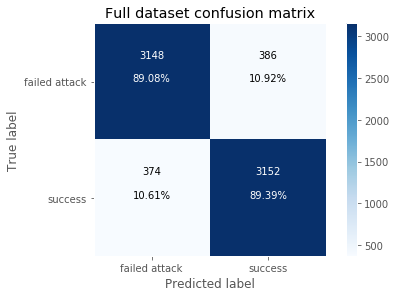

In [14]:
undersample_rfc = RandomForestClassifier()
undersample_rfc.fit(undersample_X_train, undersample_y_train)
undersample_predictions = undersample_rfc.predict(undersample_X_test)
metric_eval.classification_report(undersample_y_test, undersample_predictions
                      , classes=['failed attack','success']
                      , title='Full dataset confusion matrix');

#### Try undersampled model on full data set

             precision    recall  f1-score   support

          0       0.35      0.88      0.50      3567
          1       0.98      0.81      0.89     30503

avg / total       0.92      0.82      0.85     34070

Accuracy score 82.0%


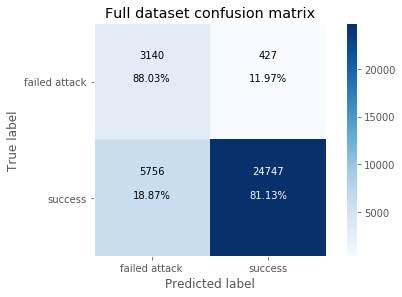

In [15]:
data_predictions = undersample_rfc.predict(data_X_test)
metric_eval.classification_report(data_y_test, data_predictions
                      , classes=['failed attack','success']
                      , title='Full dataset confusion matrix');

In [16]:
#fr = feature_selection.FeatureRanker(data_X, data_y, classify=True)
#fr.rank(by='RandomForest', plot=True);

Apparently the number of people killed (makes sense) and whether or not property was damage are strong indicators of success

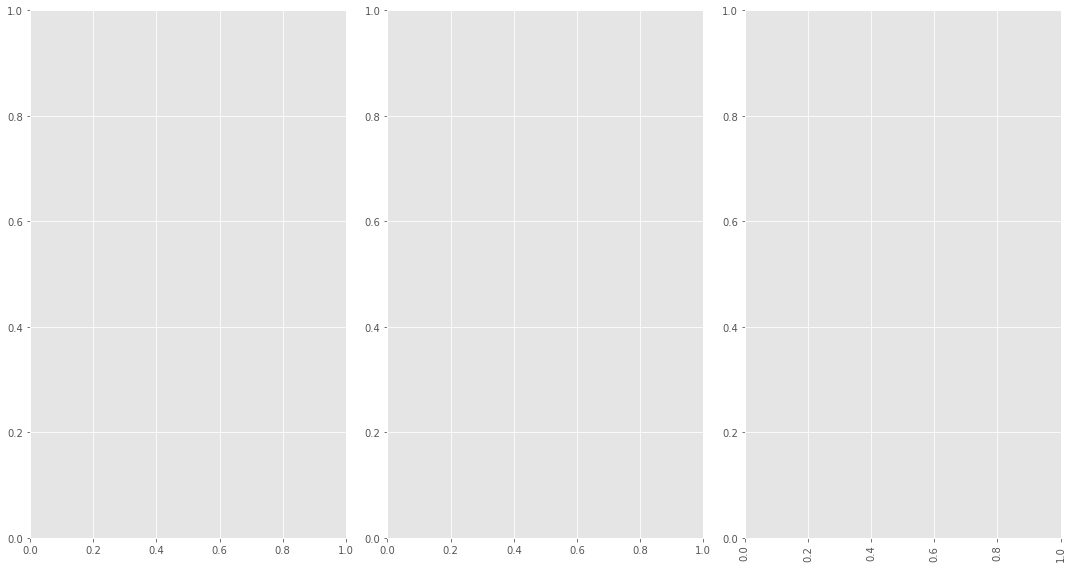

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,8))
#sns.stripplot(x='success', y='nkill',data=data, jitter=True, ax=ax1);
#sns.countplot(data=data,x='property', hue='success', ax=ax2)
#sns.countplot(data=data,x='attacktype1_txt', hue='success', ax=ax3)
plt.xticks(rotation=90)
plt.tight_layout()

In [18]:
temp = data.copy()
#sns.lmplot(x='nkill',y='nwound',data=temp, hue='success')
h = temp.copy()
h['nwound'] = np.sqrt(temp['nwound'])
#sns.lmplot(x='nkill',y='nwound',data=h, hue='success')
plt.show()

#### Try a data transformation on nkill/nwound

Text(0.5,1,'After transformation')

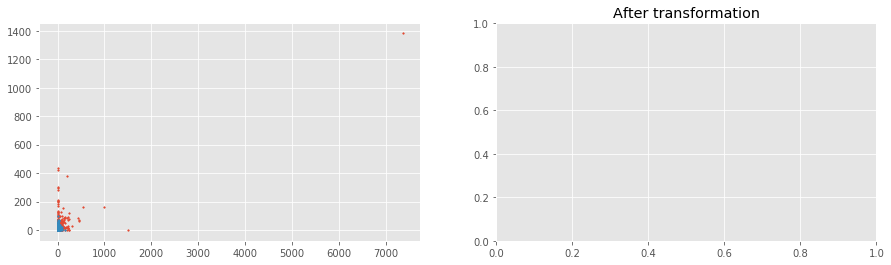

In [19]:
try1 = undersampled_data.copy()
try1 = preprocess(try1)
f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
plt.title('Original dataset')
ax1.scatter(try1[try1['success']==1]['nwound'],try1[try1['success']==1]['nkill'], s=2.5);
ax1.scatter(try1[try1['success']==0]['nwound'],try1[try1['success']==0]['nkill'], s=2.5);
plt.title('Original dataset')

def data_transform(try1):
    not_succ_temp = try1[try1['success']==0]
    #not_succ_temp['nwound'] = not_succ_temp['nwound']

    succ_temp = try1[try1['success']==1]
    succ_temp['nwound'] = succ_temp['nwound'] + 1

    try1 = pd.concat([not_succ_temp,succ_temp])
    #try1 = try1[(try1['nwound'] != 0)]
    return try1

try1 = data_transform(try1)

plt.title('After transformation')
#ax2.scatter(try1[try1['success']==1]['nwound'],try1[try1['success']==1]['nkill'], s=2.5);
#ax2.scatter(try1[try1['success']==0]['nwound'],try1[try1['success']==0]['nkill'], s=2.5);

In [20]:
try1 = preprocess(try1)
undersample_y = try1['success']
undersample_X = try1.drop('success',1)

undersample_X_train, undersample_X_test, undersample_y_train, undersample_y_test = \
                                                    train_test_split(undersample_X,
                                                                     undersample_y,
                                                                     test_size = 0.2, shuffle=True)

#### Test model from data transformation on undersampled data

             precision    recall  f1-score   support

          0       0.99      0.96      0.97      3615
          1       0.96      0.99      0.97      3445

avg / total       0.97      0.97      0.97      7060

Accuracy score 97.0%


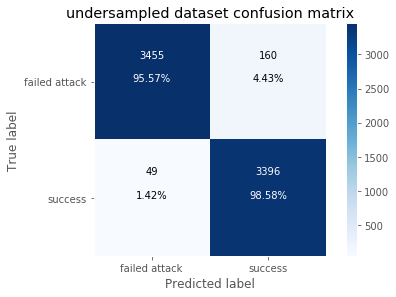

In [21]:
undersample_rfc = RandomForestClassifier(criterion='entropy', min_samples_split=50)
undersample_rfc.fit(undersample_X_train, undersample_y_train)
undersample_predictions = undersample_rfc.predict(undersample_X_test)
metric_eval.classification_report(undersample_y_test, undersample_predictions
                      , classes=['failed attack','success']
                      , title='undersampled dataset confusion matrix');

#### Test model on full data set with data transformation

             precision    recall  f1-score   support

          0       0.89      0.94      0.91      3439
          1       0.99      0.99      0.99     30631

avg / total       0.98      0.98      0.98     34070

Accuracy score 98.0%


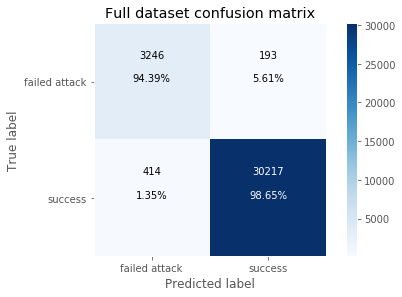

In [22]:
data_X = preprocess(data)
data_X = data_transform(data_X)
data_y = data_X['success']
data_X = data_X.drop('success',1)

# Whole dataset
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_X,data_y,
                                                                        test_size = 0.2, random_state=42)

data_predictions = undersample_rfc.predict(data_X_test)
metric_eval.classification_report(data_y_test, data_predictions
                      , classes=['failed attack','success']
                      , title='Full dataset confusion matrix');

These results indicate that the primary reason for missclassification is that the model is easily confused
by successful and unsuccessful attacks with nwound = 0
<br>
Also, at this point it is clear that the undersampled dataset is <strong>NOT</strong> better for training
in this case

## Predicting the terrorist group that carried out an attack

### Establish baseline model

In [23]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
data_known = data[data['gname'] != 'Unknown']
data_processed= preprocess(data_known)
data_y = data_processed['gname']
data_X = data_processed.drop('gname',1)
#cross_val_score(rfc, data_X, data_y, n_jobs=-1, cv=2)

Terrible accuracy on whole dataset: 20-35%

### Build model for top 10 groups + 5 randomly selected

In [24]:
# Take the top 5 groups and 15 randomly sampled groups
num_top_groups = 25
groups = list(data_known.groupby('gname')['nkill'].sum().sort_values(ascending=False).head(num_top_groups).index)
groups.extend(list(data_known.groupby('gname')['nkill'].sum()\
                   .sort_values(ascending=False)[num_top_groups:].sample(10).index))
#test_groups = [g for g in data['gname'] if g not in groups]

dfs = [data_known[data_known['gname'] == g] for g in groups]
#op_ten_test = [data_known[data_known['gname'] == g] for g in test_groups]

top_ten = pd.concat(dfs)

### Build top twenty five groups model

In [25]:
top_ten.shape[0]

44123

In [26]:
def gen_negated_test_set(other,data=data):
    test_set = []
    for idx, row in other.iterrows():
        if row['eventid'] not in data['eventid'].values:
            test_set.append(row)
    return test_set

In [27]:
# base model for new dataset
rfc = RandomForestClassifier()
top_ten_processed = preprocess(top_ten)
top_ten_y = top_ten_processed['gname']
top_ten_X = top_ten_processed.drop('gname',1)
cross_val_score(rfc,top_ten_X, top_ten_y,cv=10,n_jobs=-1,)

array([ 0.86941813,  0.98779385,  0.98959511,  0.99252548,  0.98889393,
        0.99228675,  0.99477866,  0.99409494,  0.98841436,  0.95749034])

This kind of performance probably has to do with locations of the terrorist groups being very distinct. Let's check that

In [28]:
top_ten_X_train, top_ten_X_test, top_ten_y_train, top_ten_y_test = \
                train_test_split(top_ten_X, top_ten_y, test_size=.2)
rfc_top_twenty_five = RandomForestClassifier()
rfc_top_twenty_five.fit(top_ten_X_train, top_ten_y_train)
#eda.feature_importances(rfc,top_ten_X_train);

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Looks like the hypothesis was correct.

### Same concept for bottom 1000 groups

In [29]:
num_bottom_groups = 1000
groups = list(data_known.groupby('gname')['nkill'].sum().sort_values(ascending=True).head(num_top_groups).index)
groups.extend(list(data_known.groupby('gname')['nkill'].sum()\
                   .sort_values(ascending=False)[:-num_bottom_groups].sample(10).index))

In [30]:
dfs = [data_known[data_known['gname'] == g] for g in groups]
#op_ten_test = [data_known[data_known['gname'] == g] for g in test_groups]

bottom_thousand = pd.concat(dfs)

In [ ]:
# base model for new dataset
rfc = RandomForestClassifier()
bottom_thousand_preprocessed = preprocess(bottom_thousand)
bottom_thousand_y = bottom_thousand_preprocessed['gname']
bottom_thousand_X = bottom_thousand_preprocessed.drop('gname',1)
cross_val_score(rfc,bottom_thousand_X, bottom_thousand_y,cv=10,n_jobs=-1).mean()

0.9221622369878183

This seems to prove that there is a problem because of the small number of instances per class. There is about 
3000 groups. There is ~ 40% of all instances concentrated in the top 100 groups. This means that for the 
rest of the groups, there is approximately 34 instances per group. I will need to do some research to figure 
out how to solve this problem

In [ ]:
num_top_groups = 100
groups = list(data_known.groupby('gname')['nkill'].sum().sort_values(ascending=False).head(num_top_groups).index)
groups.extend(list(data_known.groupby('gname')['nkill'].sum()\
                   .sort_values(ascending=False)[num_top_groups:].sample(10).index))
dfs = [data_known[data_known['gname'] == g] for g in groups]
top = pd.concat(dfs)
print(top.shape[0]/len(data), len(gen_negated_test_set(top)))